# Solution using `scikit-fem`

In [1]:
import skfem
import skfem.visuals.matplotlib
from skfem.helpers import grad, dot
import numpy as np

## Define 1D mesh

In this case we use the functions in `skfem` to define the mesh.

In [2]:
mesh = skfem.MeshLine(p=np.linspace(0, 1, num=101)).with_boundaries(
    {
        "left": lambda x: np.isclose(x[0], 0),
        "right": lambda x: np.isclose(x[0], 1),
    }
)
mesh

<skfem MeshLine1 object>
  Number of elements: 100
  Number of vertices: 101
  Number of nodes: 101
  Named boundaries [# facets]: left [1], right [1]

Next we plot the simple mesh, consisting of 101 points on the interval $[0,1]$.

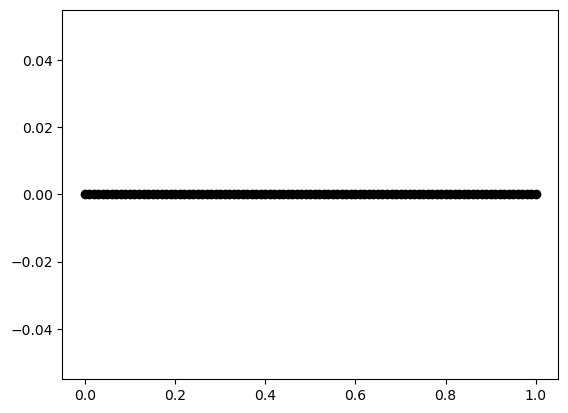

In [3]:
skfem.visuals.matplotlib.draw(mesh);

## Define function spaces
We use P1 (piecewise linear) continuous elements for the solution $u$ and the test function $v$, while we use P0 (piecewise constant) discontinuous Galerkin elements to discretize the domain-dependent parameter (which can be seen as a step function on $\Omega$).

In [4]:
# For trial and test function
basis_p1 = skfem.Basis(mesh=mesh, elem=skfem.ElementLineP1())

# For material parameter a
basis_p0 = skfem.Basis(mesh=mesh, elem=skfem.ElementDG(skfem.ElementLineP0()))

In [5]:
basis_p0

<skfem CellBasis(MeshLine1, ElementDG) object>
  Number of elements: 100
  Number of DOFs: 100
  Size: 3200 B

In [6]:
basis_p1

<skfem CellBasis(MeshLine1, ElementLineP1) object>
  Number of elements: 100
  Number of DOFs: 101
  Size: 6400 B

## Define material parameter

The array of the parameter $\sigma$ can be defined as a `numpy.array`.

In [7]:
sigma_array = np.squeeze(np.where(basis_p0.doflocs < 0.5, 1., 2.))
sigma_array

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

And then it needs to be interpolate on the quadrature points as follows.

In [8]:
sigma = basis_p0.interpolate(sigma_array)
sigma

<skfem DiscreteField object>
  Quadrature points per element: 2
  Number of elements: 100
  Order: 0
  Attributes: grad

## Assemble the system matrices

We use `skfem`'s `BilinearForm` decorator to define the left-hand side of the weak problem:

In [9]:
@skfem.BilinearForm
def stifness_matrix(u, v, w):
    # u is the solution
    # v is the test function
    # w collects the parameter function a
    return - w.sigma * dot(grad(u), grad(v))

In a similar way we define the right-hand side.

In [10]:
@skfem.LinearForm
def l(v, _):
    return 0 * v

Then we assemble the matrices.

In [11]:
S = stifness_matrix.assemble(basis_p1, sigma=sigma)
S

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 301 stored elements and shape (101, 101)>

The stiffness matrix is defined as $S_{i, j} := \int_\Omega a(x) \, v'_j(x) \, v'_i(x) \, \mathrm{d}x$ using the basis $\{v_i\}_i$ of $V$.

As this is mostly empty, it is generated as a sparse matrix. The full matrix can be generated with the `toarray` method.

In [12]:
S.toarray()

array([[-100.,  100.,    0., ...,    0.,    0.,    0.],
       [ 100., -200.,  100., ...,    0.,    0.,    0.],
       [   0.,  100., -200., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., -400.,  200.,    0.],
       [   0.,    0.,    0., ...,  200., -400.,  200.],
       [   0.,    0.,    0., ...,    0.,  200., -200.]], shape=(101, 101))

In [13]:
L = l.assemble(basis_p1)
L

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Apply Dirichlet BC

To apply the Dirichlet boundary conditions, we set the value of the solution to 0 on the left boundary and to 10 on the right.

In [14]:
u = basis_p1.zeros()
u[basis_p1.get_dofs("left")] = 0.
u[basis_p1.get_dofs("right")] = 10.

## Solve linear equations and plot

To solve the linear equation we *condense* the problem: we delete the degrees of freedom of `S`, `L`, and `u` coming from the boundary conditions indicated in `D`.

In [15]:
u = skfem.solve(*skfem.condense(S, L, x=u, D=basis_p1.get_dofs({"left", "right"})))

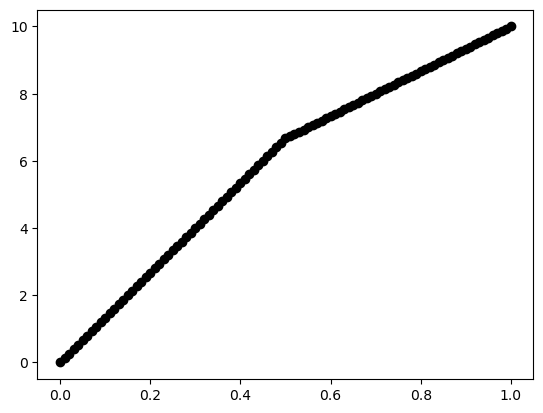

In [16]:
skfem.visuals.matplotlib.plot(mesh, u);

## Comparing analytical and FEM solutions

Last, we compare the numerical solution with the analytical one.

In [17]:
y = np.where(mesh.p[0]<0.5, mesh.p[0] * 40 / 3, (mesh.p[0] * 20 / 3) + (10/3))

In [18]:
np.linalg.norm(y - u)

np.float64(1.1118107212104367e-12)

In [19]:
import matplotlib.pyplot as plt

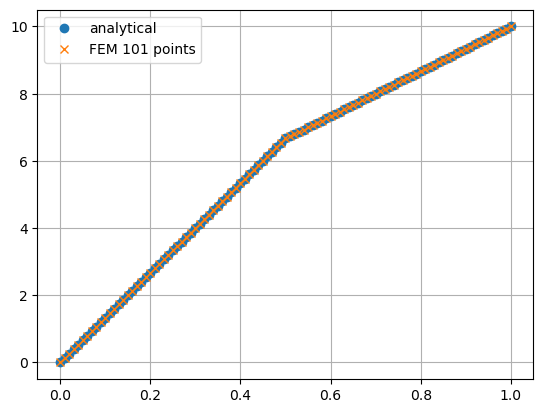

In [20]:
plt.plot(mesh.p[0], y, "o", label="analytical")
plt.plot(mesh.p[0], u, "x", label="FEM 101 points")
plt.legend()
plt.grid()
plt.show()